# Bait n' Switch

### Clickbait classification and removal

### Business problem

I have assumed the role of a data scientist working at a software company that wants to make improvements on their webbrowser deliverable. Market analysis has revealed that users are frustrated with the rise in clickbait and feel like the credibility of journalism has greatly diminished. The stakeholders want to offer our users the option to filter out or flag clickbait headlines from their browsing experience in order to set their browser apart from the others.


### Context

The online journalism economy is driven by pay perclick (PPC) advertising. Pay perclick is an advertisement payment structure where advertisers pay the website a fixed amount per click or view of their ad. Since total views are a 0 sum game, this put's pressure on website content generators to make the most eye catching and clickbaity title possible in a capitalistic arms race.

Click bait is defined as sensational and eye catching headlines or images that are designed to draw your attention and curiousity. Subjectively, clickbait is easy to spot. Take these two headlines as examples: 

 - "25 Useful Products Reviewers Say They Just Keep Buying Over And Over"
 - "US federal agency announces plans to begin presidential transition process following Trump election loss"
 
The first article grabs your curiousity, without actually telling you anything about the content of the article. It is vague but purports to be useful. This is known as exploiting a curiosity gap, saying something that peaks curiousity without giving enough information to satisfy it. Whereas the second article acts as summary of the entire article.
 
The danger of clickbait is that without any form of regulation or filtering, clickbait poises to replace conventional journalistic content creation in the hopes of generating more revenue. In addition, as clickbait headlines become more frequent, the signal to noise ratio of high integrity journalism and sensationlist false or misleading information will decrease until the two are difficult to parse. 

By giving user's the option to remove clickbait from their browser, we are potentially providing a feed back mechanism that forces content creators to write nonclickbait articles to be seen in the first place.

## Exploratory Data Analysis and Feature Engineering

 - `Sentence Structure`: I looked into title length, average word length and stopwords
 - `Title Content`: I looked at the presence of certain types of punctuation as well as the inclusion of number
 - `Title Sentiment`: News headlines should typically be neutral
 - `Vocabulary/BOW`: I took a bag of words approach and analysed tf-idf of specific words in corpus
 
## Model Selection
 - `Naive Bayes`: By far the fastest classification algorithm and considering I want build a browser extension, speed is very important factor
 - `Logistic Regression`: Allows me to modify the threshold manually in order to tweek my precision and recall however it is a slightly slower model to run
 - `Random Forest`: Power ensemble method for classfication but is relatively slow compared to other methods
 - `XGboost`: The most powerful non-neural net method for classfication but is slow
 - `Support Vector Machine`: Depending on the number of articles on the screen, the support vectors dimensionality reduction may speed up the classification and past work has indicated that it is highly effective in classifying clickbait

In [34]:
# import modules

# Utility
import pandas as pd
import numpy as np
import os
import sys
from warnings import filterwarnings
import string

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# NLP
import nltk
from textblob import TextBlob
import re
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Feature extration 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import gensim

# Statistics
from scipy import stats

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# Set a random seed
np.random.seed(42)

# magic line
%matplotlib inline

# Set theme
plt.style.use('ggplot')

#ignore warnings
filterwarnings('ignore')

# Import module
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import preprocessing as pp
from modules import graph
# ================= Uncomment if stopwords throws and error ======================== # 

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('words')

### Importing data

Datasets were generated from the raw data in the notebook `./notebooks/EDA/datasetCreation.ipynb`. The datasets were created such that there is no missing information. However, I determined in the notebook `./notebooks/EDA/exploring.ipynb` that dataset 2 contained only twitter posts which are very different to headlines, clickbait or no. I could make a seperate model for detecting twitter clickbait posts but for the current problem, I am interested only in news headlines.

In [2]:
# Import datasets
PATH1 = './src/data/dataframe1.csv'
PATH3 = './src/data/dataframe3.csv'
df1 = pd.read_csv(PATH1)
df3 = pd.read_csv(PATH3)

In [3]:
df1.head()

,text,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,0
1,"In Hollywood, the Easy-Money Generation Toughe...",0
2,1700 runners still unaccounted for in UK's Lak...,0
3,Yankees Pitchers Trade Fielding Drills for Put...,0
4,Large earthquake rattles Indonesia; Seventh in...,0


In [4]:
df3.head()

,id,post_text,title,timestamp,dataset,target
0,858462320779026433,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,3,0
1,858421020331560960,this is good,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,3,1
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,3,0
3,858323428260139008,Meet the happiest #dog in the world!,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,3,1
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,3,0


I cleaned up the columns and created a new dataset that only had the columns `text`, `dataset`, `target`. I included `dataset` so that during model evaluation, I could determine where most of the false negatives and false positives came from. 

In [5]:
PATHFINAL = './src/data/df_one_plus_three.csv'
df = pd.read_csv(PATHFINAL)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51538 entries, 0 to 51537
Data columns (total 3 columns):
title      51538 non-null object
dataset    51538 non-null int64
target     51538 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [7]:
df.shape, df[df.target == 1].shape, df[df.target == 0].shape

((51538, 3), (20760, 3), (30778, 3))

The current data set has 51438 documents, 20760 are clickbait and 30778 are not clickbait.

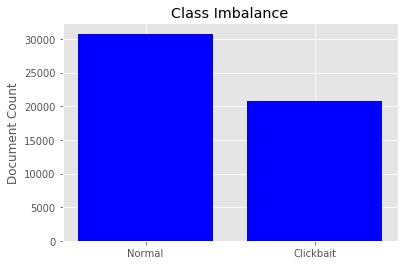

In [8]:
graph.show_class_imbalance(df)

Class imbalance can cause the classifier to tend to predict the dominant class. In my case, this would lead to a loss of sensitivity of my model as it would predict too many headlines as being normal. 

It should be noted that `dataset1` has no class imbalance and whereas `dataset3` is imbalanced almost 3:1. In order to correct for the class imbalance, I will try upsampling, smote, class_weight='balanced' and leaving it as it is.

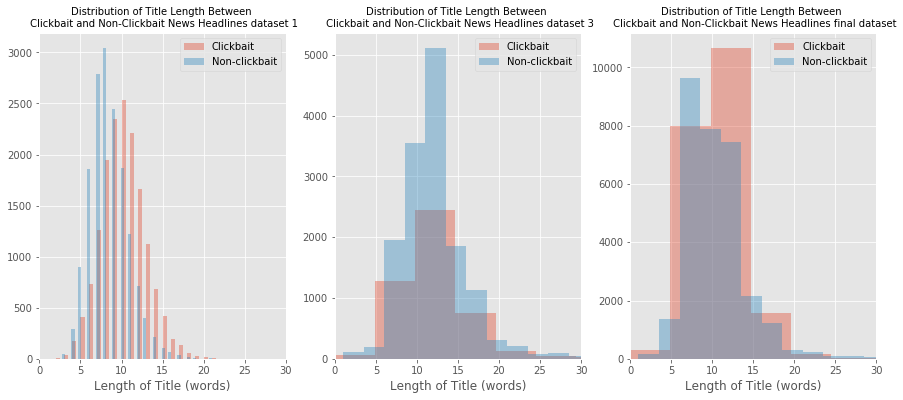

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
graph.title_lengths(df1, ax[0], content='text', x_lim=[0, 30], title='dataset 1')
graph.title_lengths(df3, ax[1], content='title', x_lim=[0, 30], title='dataset 3')
graph.title_lengths(df, ax[2], content='title', x_lim=[0, 30], title='final dataset');

Initially I suspected that there would be a large difference in the length of the words however, click bait titles show more variation in the length of the words than non click bait titles over all

In [10]:
click_lengths = (df[df.target == 1].title.apply(graph.get_len))
non_lengths = (df[df.target == 0].title.apply(graph.get_len))

click_std = np.std(click_lengths)
non_std = np.std(non_lengths)


equal_var = stats.levene(click_lengths, non_lengths)

print(f"The lengths of titles had a difference in variation of {click_std - non_std} which was significant when run through a levene's test {equal_var}")

The lengths of titles had a difference in variation of 1.1267066978193192 which was significant when run through a levene's test LeveneResult(statistic=78.71124410150307, pvalue=7.413243944769525e-19)


In [11]:
significance = stats.ttest_ind(click_lengths, non_lengths, equal_var=False)
mean_dif = int(round((click_lengths.mean()-non_lengths.mean()), 0))
print(f"Clickbait titles are on Average {mean_dif} words longer than non clickbait titles with a p value of {significance[1]}")

Clickbait titles are on Average 0 words longer than non clickbait titles with a p value of 1.4221122846913945e-20


So, though the average size of the titles did not differ, the distributions where significantly different which is supported by the results of the levenes test for equal variance.

Next, I wanted to look at at the average length of the words in the title. One would assume that clickbait titles use a shorter, snappier vocabulary however, I wanted to visualize those differences. 

Non clickbait words are on average 0.63 words longer than clickbait titles with a p value of 0.0


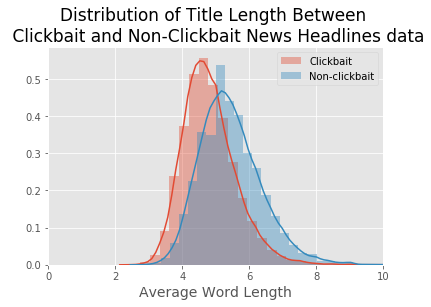

In [12]:
clickbait_words = df[df.target==1].title.apply(graph.get_average_word_length)
nonclickbait_words = df[df.target==0].title.apply(graph.get_average_word_length)
mean_difference = np.mean(nonclickbait_words) - np.mean(clickbait_words) 
p = round(stats.ttest_ind(clickbait_words, nonclickbait_words)[1], 2)
print(f"Non clickbait words are on average {round(mean_difference, 2)} words longer than clickbait titles with a p value of {p}")
graph.word_lengths(df);

As I suspected, non-click bait articles on average use slightly longer words than that of clickbait articles. Next I was interested in the content of the words.

First, I wanted to look at the `proportion of stopwords` used in each of the of the classes. This was calculated by dividing the length each title without stopwords by the same title with stopwords. To avoid a 0 division error I added 1 to the numerator and denominator. Therefore 1 is the lowest proportion possible.

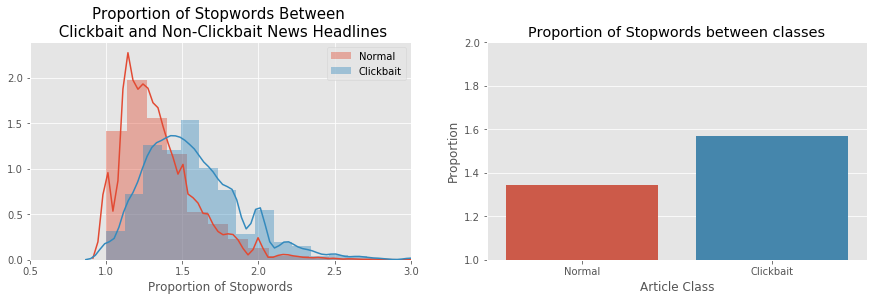

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
graph.stopword_hist(df, pp.stop_words, ax[0])
graph.stopword_bar(df, pp.stop_words, ax[1]);

As I expected, the proporiton of stopwords in the click bait headlines was higher than in Normal headlines. Though clickbait isn't strictly speaking a lie, research into lying does support this finding. Truthful statements tend to have less filler words than dishonest ones. Here we see an example of that in the reduced number of stop words in the non clickbait articles.

In addition to stopwords, I think we are all familiar with the prevelance of cardinal numbers in clickbait articles "17 reasons you have to visit jamaica" or "top 19 best hiphop songs from the 90s". Why precisely specific numbers elicit such strong curiousity is unknown but I could speculate that it provides a tangible target to disprove.

Let's examine the proportion of articles that contain cardinal numbers to those that do not.

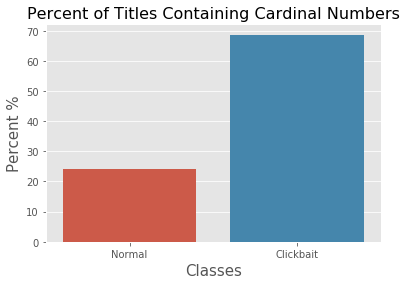

In [14]:
graph.proportion_with_cardinals(df);

70% of all clickbait titles contain cardinal numbers whereas only 20% of non-clickbait titles contain them. This is a large class divide that we can use in the model. I wonder, if the types of numbers are important. For instance, Normal news headlines will often have numbers less than 10 and also 4 digit dates. (TO DO) whereas I would expect click bait articles to be exclusively 1-100. I wouldn't expect to see any years in there at all.


Next, I will look at the actualy vocabulary of each class, to do this, I will first remove stopwords and then create and visualize frequency dictionaries.

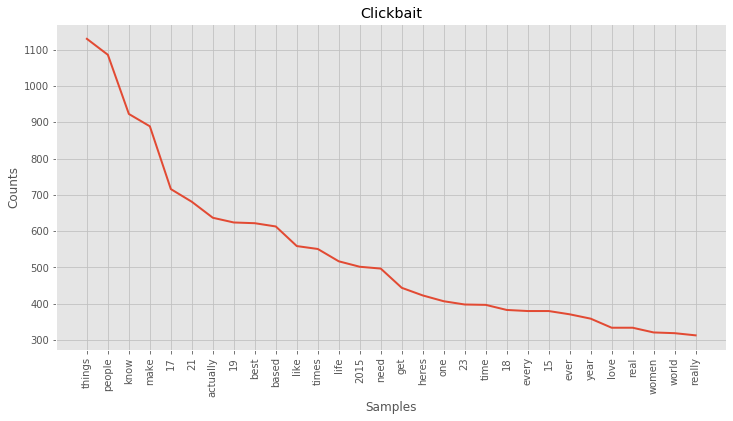

Current Vocab size is = 16392


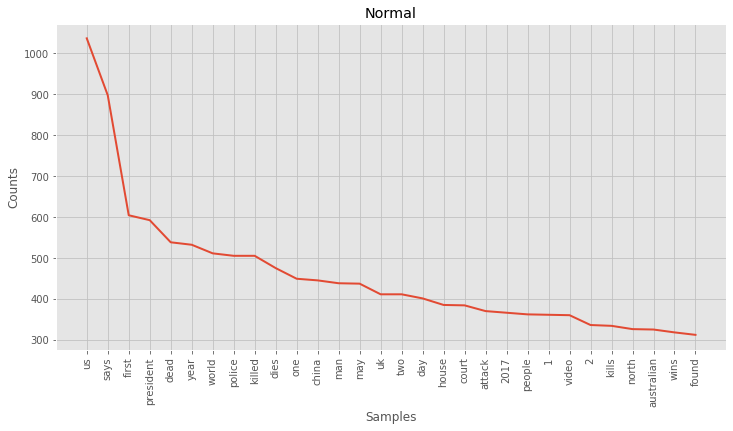

Current Vocab size is = 26456


In [15]:
# Remove stopwards
df['no_stops'] = df.title.apply(pp.remove_stopwords)

# Create frequency dictionaries
click_dict = graph.get_vocab_length(df[df.target == 1].no_stops, title="Clickbait")
normal_dict = graph.get_vocab_length(df[df.target == 0].no_stops, title="Normal")

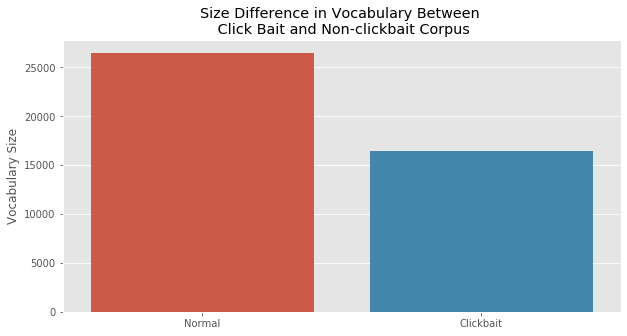

In [16]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=["Normal","Clickbait"], y=[ len(normal_dict),len(click_dict),])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

Normal headlines use a wide variety of words whereas clickbait titles use a restricted set of words. This is likely due to the limited number of subjects that clickbait covers. Usually, consumerism, pop culture and entertainment whereas Normal headlines can cover almost anything. This means that there will be a lot of unique words that only ever occur in Normal hedlines. This is strong evidence to use something like Naive Bayes are A random forest classifier. 

Let's look closer at the kinds of words that are used in each class by creating word clouds. Word clouds visualize the frequency of words by their relative size.


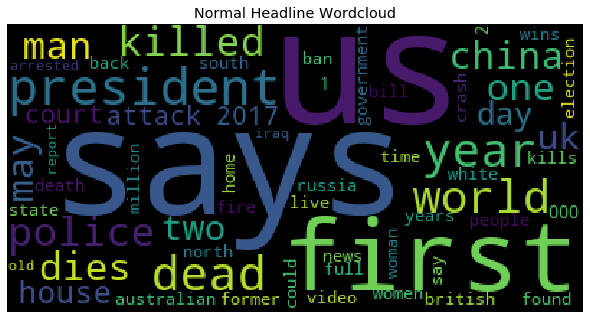

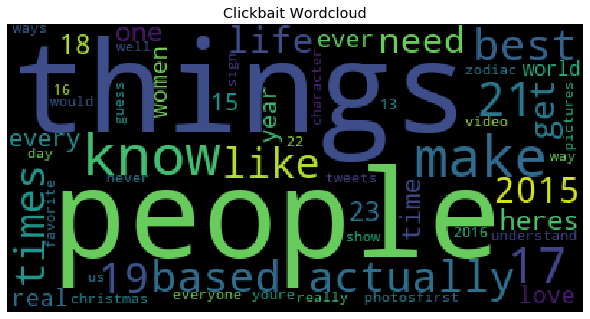

In [17]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(normal_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Normal Headline Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(click_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

What stood out to me immediately was the generic use of language in clickbait as appposed to the specificity of language in Normal headlines. But let's be more specific about that. I will use TextBlob to analyse part of speech for each of the words and the map eac word to the part of speech and make a second round of word clouds.

# Warning Area Currently Under Construction

In [18]:
def get_tags(vocab):
    return [TextBlob(word).tags[0][1] for word in vocab]

In [19]:
norm_tag = get_tags(normal_dict.keys())
click_tag = get_tags(click_dict.keys())

In [20]:
def countX(lst, x): 
    return lst.count(x) 
def freq_of_specific_words(tokenized_list, list_of_interest):
    freqDict = {}
    for word in list_of_interest:
        freqDict[word] = countX(tokenized_list, word)
    return freqDict

In [21]:
norm_tag_dict = freq_of_specific_words(norm_tag, set(norm_tag))
click_tag_dict = freq_of_specific_words(click_tag, set(click_tag))

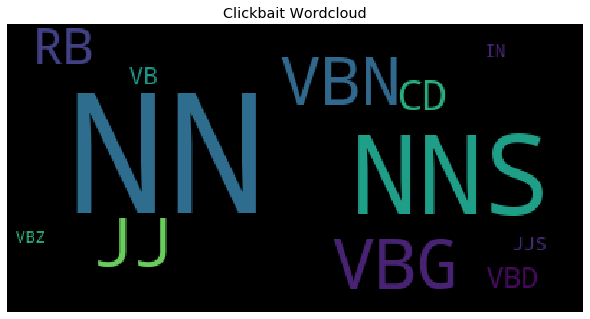

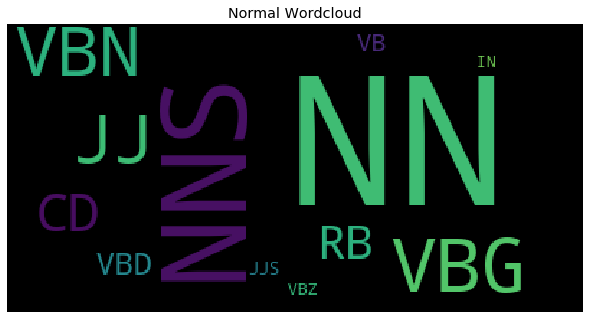

In [22]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(click_tag_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(norm_tag_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Normal Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

# End of Construction

In [23]:
df.title.apply(graph.get_subjectivity)


0        0.000000
1        0.000000
2        0.100000
3        0.000000
4        0.428571
           ...   
51533    1.000000
51534    0.000000
51535    0.497273
51536    0.000000
51537    0.000000
Name: title, Length: 51538, dtype: float64

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [26]:
def get_polarity(title):
    return analyzer.polarity_scores(title.lower())['compound']

In [27]:
click_polarity = df[df.target==1].title.apply(get_polarity)
normal_polarity = df[df.target==0].title.apply(get_polarity)

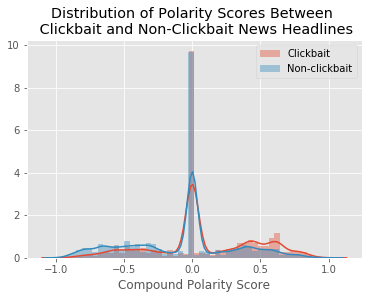

In [28]:
fig, ax = plt.subplots()
for a, b in zip([click_polarity, normal_polarity], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=50, ax=ax, kde=True, label=b)
    plt.legend()
# ax.set_xlim([0, 100])
ax.set_xlabel("Compound Polarity Score")
ax.set_title("Distribution of Polarity Scores Between \n Clickbait and Non-Clickbait News Headlines");

The vast majority of headlines fall with the central or neutral range. However, the number of clickbait headlines that are net positive or greater than 0.5 is greater.

# To be continued. 
- Sentence structure analysis
- Subject Determiners

# Baseline modelling

I will use tf-idf after a train test split in conjunction with a decision tree, logistic regressor and a bayes classifier to find suitable baseline model.

In [98]:
# Train test split
X = df.title
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state=5,
                                                    stratify=df.dataset) # To insure that data sets are equally represented


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41230,), (10308,), (41230,), (10308,))

In [99]:
# Clean the data
X_train = X_train.apply(pp.preprocess)
X_test = X_test.apply(pp.preprocess)

# Instantiate my tfidf Vectorizer
tfidf = TfidfVectorizer(stop_words = pp.stop_words, ngram_range=(1,2),)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((41230, 215519), (10308, 215519))

In [102]:
# Instantiate models
bayes_clf = BernoulliNB(alpha=0.01)
log_clf = LogisticRegressionCV(class_weight='balanced', cv=10, penalty='l2', Cs = 100)
# for_clf = RandomForestClassifier(n_estimators = 100)

In [103]:
# fit models
bayes_clf.fit(X_train_tfidf, y_train)
log_clf.fit(X_train_tfidf, y_train)
# for_clf.fit(X_train_tfidf, y_train)

LogisticRegressionCV(Cs=100, class_weight='balanced', cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [104]:
# predict on models training
y_hat_bayes_tr = bayes_clf.predict(X_train_tfidf)
y_hat_log_tr = log_clf.predict(X_train_tfidf)
# y_hat_for_tr = for_clf.predict(X_train_tfidf)

# Predict on models testing
y_hat_bayes_te = bayes_clf.predict(X_test_tfidf)
y_hat_log_te = log_clf.predict(X_test_tfidf)
# y_hat_for_te = for_clf.predict(X_test_tfidf)

In [105]:
# Evaluate training
f1_bayes_tr = f1_score(y_train, y_hat_bayes_tr)
f1_log_tr = f1_score(y_train, y_hat_log_tr)
# f1_for_tr = f1_score(y_train, y_hat_for_tr)


f1_bayes_te = f1_score(y_test, y_hat_bayes_te)
f1_log_te = f1_score(y_test, y_hat_log_te)
# f1_for_te = f1_score(y_test, y_hat_for_te)

In [106]:
# Eval continued:

print(f"Training scores: {f1_bayes_tr, f1_log_tr, f1_for_tr} \n\n Testing Scores: {f1_bayes_te, f1_log_te, f1_for_te}")

Training scores: (0.9947694342571995, 0.9907507507507507, 0.9972180223767765) 

 Testing Scores: (0.8421426037601986, 0.8431466030989273, 0.8037505451373747)


Out of the box, bayes and logistic regression perform the best. I believe that an XGboosted algorithm will outperform both of them.